<a href="https://colab.research.google.com/github/Jagritimaurya82/Image-Classifiaction/blob/main/Dog_vs_Cat___classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Import Library

In [ ]:
#about torch...
import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

#using numpy
import numpy as np

#for data load or save
import pandas as pd

#visualize some datasets
import matplotlib.pyplot as plt

#check our work directory
import os

#to unzip datasets
import zipfile

# Hyper parameters Setting

In [ ]:
lr = 0.001 # learning_rate
batch_size = 100 # we will use mini-batch method
epochs = 100 # How much to train a model

In [ ]:
#Set seed and Random Value
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)

# Load train, test data

In [ ]:
os.makedirs('/content/gdrive/MyDrive/data', exist_ok=True)

In [ ]:
base_dir = '/content/gdrive/MyDrive'
train_dir = '/content/gdrive/MyDrive/data/train_200'
test_dir = '/content/gdrive/MyDrive/data/test_50'

In [ ]:
# with zipfile.ZipFile(os.path.join(base_dir, 'train.zip')) as train_zip:
#     train_zip.extractall('/content/gdrive/MyDrive/data')
    
# with zipfile.ZipFile(os.path.join(base_dir, 'test.zip')) as test_zip:
#     test_zip.extractall('/content/gdrive/MyDrive/data')

In [ ]:
os.listdir(test_dir)[:5]

['5.jpg', '19.jpg', '4.jpg', '11.jpg', '13.jpg']

In [ ]:
import glob

train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

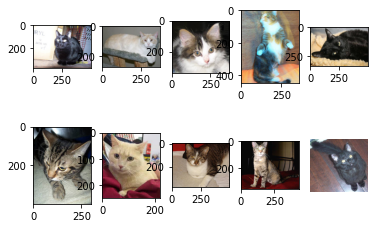

In [ ]:
#check our datasets
from PIL import Image
# random_idx = np.random.randint(1,25000,size=10)
random_idx = np.random.randint(1,100,size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = Image.open(train_list[idx])
    plt.imshow(img)
    i+=1

plt.axis('off')
plt.show()

In [ ]:
train_list[5]

'/content/gdrive/MyDrive/data/train_200/cat.10002.jpg'

In [ ]:
int(test_list[0].split('/')[-1].split('.')[0])

5

In [ ]:

print(len(train_list), len(test_list))

200 50


In [ ]:
from sklearn.model_selection import train_test_split
train_list, val_list = train_test_split(train_list, test_size=0.2)

In [ ]:
#data Augumentation
train_transforms =  transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])


test_transforms = transforms.Compose([   
    transforms.Resize((224, 224)),
     transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])

In [ ]:
class dataset(torch.utils.data.Dataset):
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform
        
        
    #dataset length
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    #load an one of images
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label=1
        elif label == 'cat':
            label=0
            
        return img_transformed,label

In [ ]:
train_data = dataset(train_list, transform=train_transforms)
test_data = dataset(test_list, transform=test_transforms)
val_data = dataset(val_list, transform=test_transforms)

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=True)

In [ ]:
print(len(train_data), len(train_loader))

160 2


In [ ]:
print(len(val_data), len(val_loader))

40 1


In [ ]:
#check our images shape
train_data[0][0].shape

torch.Size([3, 224, 224])

# build Model


1.   3 Convolution layer and 2 fully connected layer
2.   batchNormalization for limit overfitting


 
 




In [ ]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
model = Cnn().to(device)
model.train()

Cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

# set Loss function and optimizer


In [ ]:
optimizer = optim.Adam(params = model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

# Train our Network

In [ ]:
epochs = 100

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    
    for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)
        
        output = model(data)
        loss = criterion(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        acc = ((output.argmax(dim=1) == label).float().mean())
        epoch_accuracy += acc/len(train_loader)
        epoch_loss += loss/len(train_loader)
        
    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
    with torch.no_grad():
        epoch_val_accuracy=0
        epoch_val_loss =0
        for data, label in val_loader:
            data = data.to(device)
            label = label.to(device)
            
            val_output = model(data)
            val_loss = criterion(val_output,label)
            
            
            acc = ((val_output.argmax(dim=1) == label).float().mean())
            epoch_val_accuracy += acc/ len(val_loader)
            epoch_val_loss += val_loss/ len(val_loader)
            
        print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))

Epoch : 1, train accuracy : 0.574999988079071, train loss : 0.6801025867462158
Epoch : 1, val_accuracy : 0.699999988079071, val_loss : 0.6466010212898254
Epoch : 2, train accuracy : 0.5766666531562805, train loss : 0.675438404083252
Epoch : 2, val_accuracy : 0.6000000238418579, val_loss : 0.6559351682662964
Epoch : 3, train accuracy : 0.6050000190734863, train loss : 0.6623513698577881
Epoch : 3, val_accuracy : 0.574999988079071, val_loss : 0.668425977230072
Epoch : 4, train accuracy : 0.5649999976158142, train loss : 0.6703084707260132
Epoch : 4, val_accuracy : 0.6499999761581421, val_loss : 0.6536931395530701
Epoch : 5, train accuracy : 0.6100000143051147, train loss : 0.6533309817314148
Epoch : 5, val_accuracy : 0.550000011920929, val_loss : 0.6893430352210999
Epoch : 6, train accuracy : 0.6116666793823242, train loss : 0.6430600881576538
Epoch : 6, val_accuracy : 0.6000000238418579, val_loss : 0.6801470518112183
Epoch : 7, train accuracy : 0.6416666507720947, train loss : 0.6347520

In [ ]:
torch.save(model.state_dict(), '/content/gdrive/MyDrive/dog_vs_cat_200.pth')

In [ ]:
torch.save(model.state_dict(), '/content/gdrive/MyDrive/dog_vs_cat.pth')

In [ ]:
dog_probs = []
model.eval()
with torch.no_grad():
    for data, fileid in test_loader:
        data = data.to(device)
        preds = model(data)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        dog_probs += list(zip(list(fileid), preds_list))

In [ ]:
dog_probs.sort(key = lambda x : int(x[0]))
dog_probs

[('1', 0.38094043731689453),
 ('2', 0.08042670786380768),
 ('3', 0.41623759269714355),
 ('4', 0.7728818655014038),
 ('5', 0.2564895451068878),
 ('6', 0.302531361579895),
 ('7', 0.3699454367160797),
 ('8', 0.4840944707393646),
 ('9', 0.4075988829135895),
 ('10', 0.33595454692840576),
 ('11', 0.12034670263528824),
 ('12', 0.19956880807876587),
 ('13', 0.40459540486335754),
 ('14', 0.31058043241500854),
 ('15', 0.8089295029640198),
 ('16', 0.06972628831863403),
 ('17', 0.4800560474395752),
 ('18', 0.2680613398551941),
 ('19', 0.11255114525556564),
 ('20', 0.7945235967636108),
 ('21', 0.1458166539669037),
 ('22', 0.7915182709693909),
 ('23', 0.25244876742362976),
 ('24', 0.35895347595214844),
 ('25', 0.05421743169426918),
 ('26', 0.8362911939620972),
 ('27', 0.5359734892845154),
 ('28', 0.2617601454257965),
 ('29', 0.644210159778595),
 ('30', 0.2490898072719574),
 ('31', 0.15117380023002625),
 ('32', 0.23216365277767181),
 ('33', 0.7317957282066345),
 ('34', 0.1450013816356659),
 ('35', 0.

In [ ]:
idx = list(map(lambda x: x[0],dog_probs))
prob = list(map(lambda x: x[1],dog_probs))

In [ ]:
submission = pd.DataFrame({'id':idx,'label':prob})

In [ ]:
submission

,id,label
0,1,0.423538
1,2,0.453563
2,3,0.416477
3,4,0.485397
4,5,0.416512
5,6,0.496902
6,7,0.438368
7,8,0.464090
8,9,0.437499
9,10,0.422456


In [ ]:
submission.to_csv('result.csv',index=False)

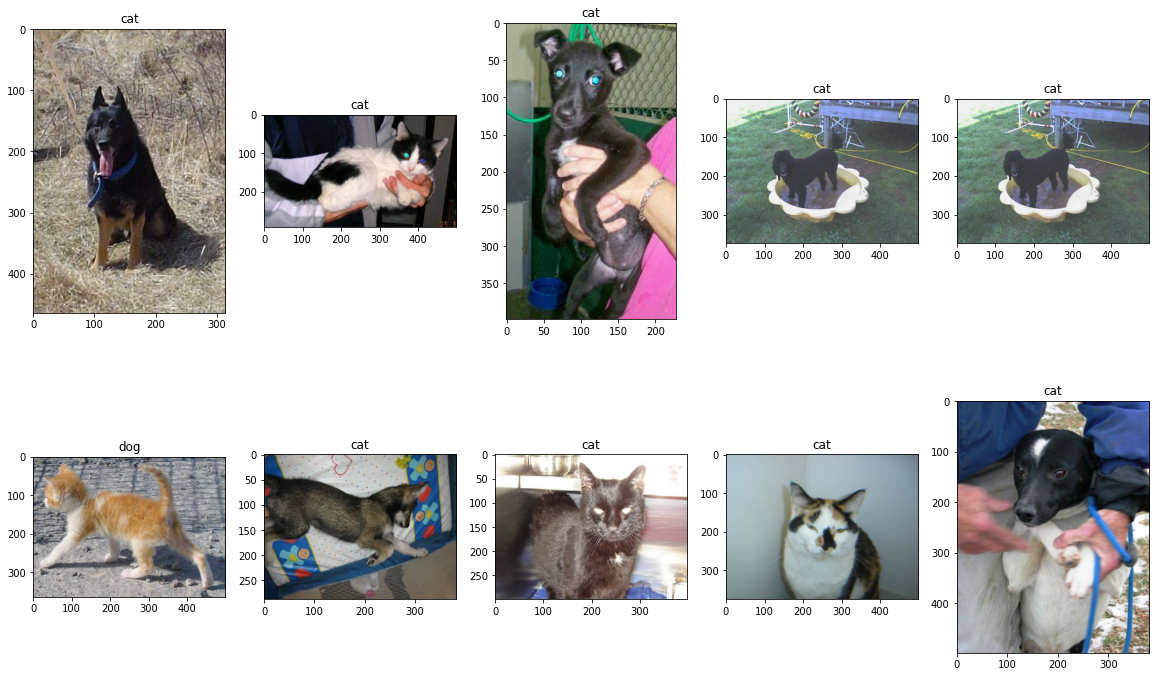

In [ ]:
import random

id_list = []
class_ = {0: 'cat', 1: 'dog'}

fig, axes = plt.subplots(2, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():
    
    i = random.choice(submission['id'].values)
    
    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0
        
    img_path = os.path.join(test_dir, '{}.jpg'.format(i))
    img = Image.open(img_path)
    
    ax.set_title(class_[label])
    ax.imshow(img)